In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
from imutils.paths import list_images
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import os
import pickle
from typing import List

In [ ]:
def load_split (path) :
  imagePaths = list (paths . list_images (path) )
  data = []
  labels = []
  for imagePath in imagePaths:
    label = imagePath . split (os . path . sep) [-2]
    image = cv2. imread(imagePath)
    image = cv2. cvtColor(image, cv2. COLOR_BGR2GRAY)
    image = cv2. resize (image, (200, 200) )
    image = cv2. threshold(image, 0, 255,
    cv2.THRESH_BINARY_INV | cv2. THRESH_OTSU) [1]
    features = quantify_image (image)
    data.append(features)
    labels.append(label)
  return (np . array (data) , np . array(labels) )


In [ ]:
def quantify_image(image):
  features=feature.hog(image,orientations=9,pixels_per_cell=(10,10),cells_per_block=(2,2),transform_sqrt= True ,block_norm="L1")
  return features

In [ ]:
trainingpath=r"/content/drive/MyDrive/dataset/spiral/training"
testingpath=r"/content/drive/MyDrive/dataset/spiral/testing"

(X_train,y_train)=load_split(trainingpath)
(X_test,y_test)=load_split(testingpath)

In [ ]:
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)
print(X_train.shape,y_train.shape)

(72, 12996) (72,)


In [ ]:
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train,y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


NameError: ignored

In [ ]:
testingpaths=list(paths.list_images(testingpath))
idxs=np.arange(0,len(testingpaths))
idxs=np.random.choice(idxs,size=(25,),replace=False)
images=[]

In [ ]:
for i in idxs:
  image=cv2.imread(testingpaths[i])
  output=image.copy()
  output=cv2.resize(output,(128,128))
  image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  image=cv2.resize(image,(200,200))
  image=cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
  features=quantify_image(image)
  pred=model.predict([features])
  label=le.inverse_transform(pred)[0]
  color=(0,255,0) if label=="healthy" else (0,0,255)
  cv2.putText(output,label,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
  images.append(output)



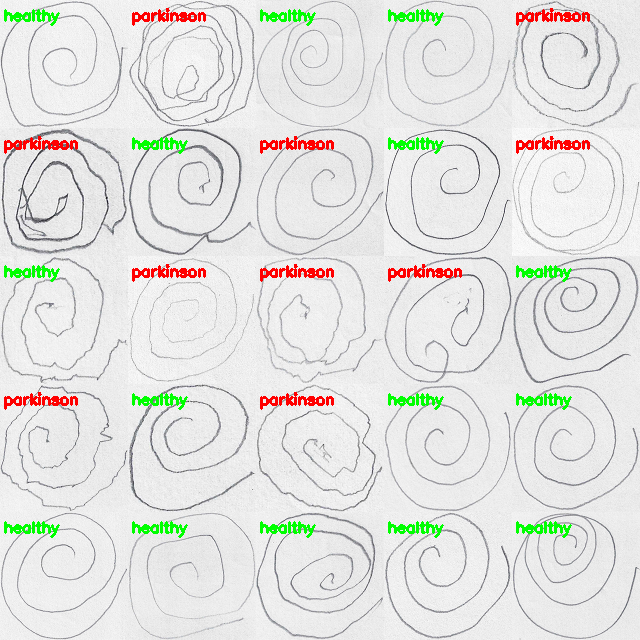

In [ ]:
montage=build_montages(images,(128,128),(5,5))[0]
cv2_imshow(montage)




In [ ]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test,predictions).flatten()
print(cm)
(tn,fp,fn,tp) = cm
accuracy = (tp+tn)/float(cm.sum())
print(accuracy)

[14  1  4 11]
0.8333333333333334


In [ ]:
pickle.dump(model,open('parkinson.pkl','wb'))